load modules

In [1]:
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import numpy as np
import os
import matplotlib.pyplot as plt
from osgeo import gdal, osr
import cStringIO
from PIL import Image
import PIL
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta

In [2]:
# (C) British Crown Copyright 2011 - 2012, Met Office
#
# This file is part of cartopy.
#
# cartopy is free software: you can redistribute it and/or modify it under
# the terms of the GNU Lesser General Public License as published by the
# Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# cartopy is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with cartopy.  If not, see <http://www.gnu.org/licenses/>.
"""
This module defines :class:`Feature` instances, for use with
ax.add_feature().

"""
from abc import ABCMeta, abstractmethod
import os.path

import numpy as np
import shapely.geometry

import cartopy.io.shapereader as shapereader
import cartopy.crs


COLORS = {'land': np.array((240, 240, 220)) / 256.,
          'land_alt1': np.array((220, 220, 220)) / 256.,
          'water': np.array((152, 183, 226)) / 256.}
"""
A dictionary of colors useful for drawing Features.

The named keys in this dictionary represent the "type" of
feature being plotted.

"""


_NATURAL_EARTH_GEOM_CACHE = {}
"""
Caches a mapping between (name, category, scale) and a tuple of the
resulting geometries.

Provides a significant performance benefit (when combined with object id
caching in GeoAxes.add_geometries) when producing multiple maps of the
same projection.

"""


class Feature(object):
    """
    Represents a collection of points, lines and polygons with convenience
    methods for common drawing and filtering operations.

    Args:

        * crs - the coordinate reference system of this Feature

    Kwargs:
        Keyword arguments to be used when drawing this feature.

    .. seealso::

        To add features to the current matplotlib axes, see
        :func:`GeoAxes <cartopy.mpl.geoaxes.GeoAxes.add_feature>`.

    """
    __metaclass__ = ABCMeta

    def __init__(self, crs, **kwargs):
        self._crs = crs
        self._kwargs = dict(kwargs)

    @property
    def crs(self):
        """The cartopy CRS for the geometries in this feature."""
        return self._crs

    @property
    def kwargs(self):
        """
        The read-only dictionary of keyword arguments that are used when
        creating the matplotlib artists for this feature.

        """
        return dict(self._kwargs)

    @abstractmethod
    def geometries(self):
        """
        Returns an iterator of (shapely) geometries for this feature.

        """
        pass

    def intersecting_geometries(self, extent):
        """
        Returns an iterator of shapely geometries that intersect with
        the given extent. The extent is assumed to be in the CRS of
        the feature. If extent is None, the method returns all
        geometries for this dataset.

        """
        if extent is not None:
            extent_geom = shapely.geometry.box(extent[0], extent[2],
                                               extent[1], extent[3])
            return (geom for geom in self.geometries() if
                    extent_geom.intersects(geom))
        else:
            return self.geometries()


class ShapelyFeature(Feature):
    """
    A class capable of drawing a collection of
    shapely geometries.

    """
    def __init__(self, geometries, crs, **kwargs):
        """
        Args:

        * geometries:
            A collection of shapely geometries.
        * crs:
            The cartopy CRS in which the provided geometries are defined.

        Kwargs:
            Keyword arguments to be used when drawing this feature.

        """
        super(ShapelyFeature, self).__init__(crs, **kwargs)
        self._geoms = tuple(geometries)

    def geometries(self):
        return iter(self._geoms)


class NaturalEarthFeature(Feature):
    """
    A simple interface to Natural Earth shapefiles.

    See http://www.naturalearthdata.com/

    """
    def __init__(self, category, name, scale, **kwargs):
        """
        Args:

        * category:
            The category of the dataset, i.e. either 'cultural' or 'physical'.
        * name:
            The name of the dataset, e.g. 'admin_0_boundary_lines_land'.
        * scale:
            The dataset scale, i.e. one of '10m', '50m', or '110m'.
            Corresponding to 1:10,000,000, 1:50,000,000, and 1:110,000,000
            respectively.

        Kwargs:
            Keyword arguments to be used when drawing this feature.

        """
        super(NaturalEarthFeature, self).__init__(cartopy.crs.PlateCarree(),
                                                  **kwargs)
        self.category = category
        self.name = name
        self.scale = scale

    def geometries(self):
        key = (self.name, self.category, self.scale)
        if key not in _NATURAL_EARTH_GEOM_CACHE:
            path = shapereader.natural_earth(resolution=self.scale,
                                             category=self.category,
                                             name=self.name)
            geometries = tuple(shapereader.Reader(path).geometries())
            _NATURAL_EARTH_GEOM_CACHE[key] = geometries
        else:
            geometries = _NATURAL_EARTH_GEOM_CACHE[key]

        return iter(geometries)


class GSHHSFeature(Feature):
    """
    An interface to the GSHHS dataset.

    See http://www.ngdc.noaa.gov/mgg/shorelines/gshhs.html

    Args:

    * scale:
        The dataset scale. One of 'auto', 'coarse', 'low', 'intermediate',
        'high, or 'full' (default is 'auto').
    * levels:
        A list of integers 1-4 corresponding to the desired GSHHS feature
        levels to draw (default is [1] which corresponds to coastlines).

    Kwargs:
        Keyword arguments to be used when drawing the feature. Defaults
        are edgecolor='black' and facecolor='none'.

    """

    _geometries_cache = {}
    """
    A mapping from scale and level to GSHHS shapely geometry::

        {(scale, level): geom}

    This provides a perfomance boost when plotting in interactive mode or
    instantiating multiple GSHHS artists, by reducing repeated file IO.

    """
    def __init__(self, scale='auto', levels=None, **kwargs):
        super(GSHHSFeature, self).__init__(cartopy.crs.PlateCarree(), **kwargs)

        if scale not in ('auto', 'a', 'coarse', 'c', 'low', 'l',
                         'intermediate', 'i', 'high', 'h', 'full', 'f'):
            raise ValueError("Unknown GSHHS scale '{}'.".format(scale))
        self._scale = scale

        if levels is None:
            levels = [1]
        self._levels = set(levels)
        unknown_levels = self._levels.difference([1, 2, 3, 4])
        if unknown_levels:
            raise ValueError("Unknown GSHHS levels "
                             "'{}'.".format(unknown_levels))

        # Default kwargs
        self._kwargs.setdefault('edgecolor', 'black')
        self._kwargs.setdefault('facecolor', 'none')

    def _scale_from_extent(self, extent):
        """
        Returns the appropriate scale (e.g. 'i') for the given extent
        expressed in PlateCarree CRS.

        """
        # Default to coarse scale
        scale = 'c'

        if extent is not None:
            # Upper limit on extent in degrees.
            scale_limits = (('c', 20.0),
                            ('l', 10.0),
                            ('i', 2.0),
                            ('h', 0.5),
                            ('f', 0.1))

            width = abs(extent[1] - extent[0])
            height = abs(extent[3] - extent[2])
            min_extent = min(width, height)
            if min_extent != 0:
                for scale, limit in scale_limits:
                    if min_extent > limit:
                        break

        return scale

    def geometries(self):
        return self.intersecting_geometries(extent=None)

    def intersecting_geometries(self, extent):
        if self._scale == 'auto':
            scale = self._scale_from_extent(extent)
        else:
            scale = self._scale[0]

        if extent is not None:
            extent_geom = shapely.geometry.box(extent[0], extent[2],
                                               extent[1], extent[3])
        for level in self._levels:
            geoms = GSHHSFeature._geometries_cache.get((scale, level))
            if geoms is None:
                # Load GSHHS geometries from appropriate shape file.
                # TODO selective load based on bbox of each geom in file.
                path = shapereader.gshhs(scale, level)
                geoms = tuple(shapereader.Reader(path).geometries())
                GSHHSFeature._geometries_cache[(scale, level)] = geoms
            for geom in geoms:
                if extent is None or extent_geom.intersects(geom):
                    yield geom


BORDERS = NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land',
                              '10m', edgecolor='black', facecolor='none')
"""Small scale (1:110m) country boundaries."""


COASTLINE = NaturalEarthFeature('physical', 'coastline', '10m',
                                edgecolor='black', facecolor='none')
"""Small scale (1:110m) coastline, including major islands."""


LAKES = NaturalEarthFeature('physical', 'lakes', '10m',
                            edgecolor='face',
                            facecolor=COLORS['water'])
"""Small scale (1:110m) natural and artificial lakes."""


LAND = NaturalEarthFeature('physical', 'land', '10m',
                           edgecolor='face',
                           facecolor=COLORS['land'])
"""Small scale (1:110m) land polygons, including major islands."""


OCEAN = NaturalEarthFeature('physical', 'ocean', '10m',
                            edgecolor='face',
                            facecolor=COLORS['water'])
"""Small scale (1:110m) ocean polygons."""


RIVERS = NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',
                             edgecolor=COLORS['water'],
                             facecolor='none')
"""Small scale (1:110m) single-line drainages, including lake centerlines."""

'Small scale (1:110m) single-line drainages, including lake centerlines.'

Mask the places where values is NaN if there, Get the coordiantes and create grid with coordinates

In [3]:
def listall(RootFolder, varname=''):
    lists = [os.path.join(root, name)    
                 for root, dirs, files in os.walk(RootFolder)
                   for name in files
                   if varname in name
                     if name.endswith('.tif')]
    return lists

def setMap(rasterBase):

    # Read the data and metadata
    ds = gdal.Open(rasterBase)
    #band = ds.GetRasterBand(20)
    
    data = ds.ReadAsArray()
    gt = ds.GetGeoTransform()
    proj = ds.GetProjection()
    
    nan = ds.GetRasterBand(1).GetNoDataValue()
    if nan != None:
        data = np.ma.masked_equal(data,value=nan)
    
    xres = gt[1]
    yres = gt[5]
    
    # get the edge coordinates and add half the resolution 
    # to go to center coordinates
    xmin = gt[0] + xres * 0.5
    xmax = gt[0] + (xres * ds.RasterXSize) - xres * 0.5
    ymin = gt[3] + (yres * ds.RasterYSize) + yres * 0.5
    ymax = gt[3] - yres * 0.5
    
    x = ds.RasterXSize 
    y = ds.RasterYSize  
    extent = [ gt[0],gt[0]+x*gt[1], gt[3],gt[3]+y*gt[5]]
    #ds = None
    
    # create a grid of xy coordinates in the original projection
    xy_source = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]
    
    return extent, xy_source, proj

Function to create continuous custom colorbar

In [4]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)
c = mcolors.ColorConverter().to_rgb

Define a colorbar

In [5]:
phase = make_colormap([c('#781800'), c('#B34700'),0.1, c('#B34700'), c('#F09400'),0.2, c('#F09400'), c('#FFBE3B'), 0.3, 
                       c('#FFBE3B'), c('#FFD88A'),0.4, c('#FFD88A'), c('#FFFFFF'),0.5, c('#FFFFFF'), c('#B6D676'), 0.6,
                       c('#B6D676'), c('#8BBA2D'),0.7, c('#8BBA2D'), c('#60A100'),0.8, c('#60A100'), c('#1B8500'), 0.9,
                       c('#1B8500'), c('#006915')])

Get mask from another TIFie

In [ ]:
# folder = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\InnerMongolia\NDVI_2009\DaySums_StdNormAnomalyRes_3857//'
# psdxx = folder+'TRMM_CQ_2009001.tif.tif'

# path_NDVI = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\InnerMongolia\NDVI_2009\DaySums_StdNormAnomalyRes_3857//TRMM_CQ_2009001.tif.tif'
# ds_ndvi = gdal.Open(path_NDVI).ReadAsArray()

# ds2 = gdal.Open(psdxx)
# array2 = ds2.ReadAsArray()
# array2 = np.ma.masked_where(ds_ndvi == ds_ndvi[0][0], array2)
# array2 = np.flipud(array2)   
# array2 = np.ma.masked_equal(array2, array2.max())
# array2 = np.ma.masked_equal(array2, array2.min())
# print array2.shape

Get extent and of basemap and use this information for all following

In [6]:
#RasterFolder = r'D:\Data\MOD13C1_NDVI'
raster = r'D:\Data\MOD13C1_NDVI//wcs2_raw.tif'#listall(RasterFolder[-1])
print raster
#raster = raster[2191:2556]
rasterBase = raster
extent, xy_source, proj = setMap(rasterBase)
print extent
print proj
#print raster[0], raster[-1]

D:\Data\MOD13C1_NDVI//wcs2_raw.tif
[-180.0, 180.0, 90.0, -90.0]
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]


Flip the array to display

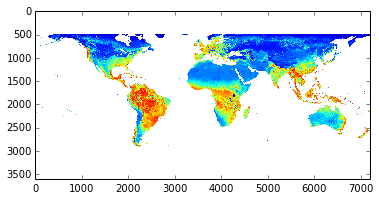

In [7]:
ds = gdal.Open(rasterBase)
array = ds.ReadAsArray()
array = np.ma.masked_where(array == 0, array)
array = array/10000.
plt.imshow(array)
img = np.flipud(array)
img_extent = (extent[0], extent[1], extent[2], extent[3])

In [8]:
trans =ds.GetGeoTransform()
extent2 = (trans[0], trans[0] + ds.RasterXSize*trans[1],
          trans[3] + ds.RasterYSize*trans[5], trans[3])
print extent2

(-180.0, 180.0, -90.0, 90.0)


-0.0565 0.7769


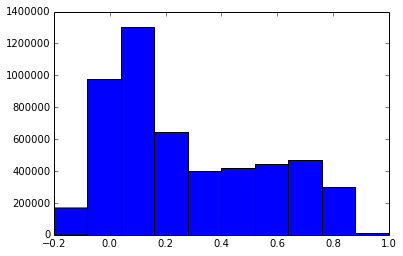

In [9]:
plt.hist(array.compressed())

bot = np.percentile(array.compressed(), 5)
top = np.percentile(array.compressed(), 95)
print bot,top

In [10]:
ex0 = round(img_extent[0],8) 
ex1 = round(img_extent[1],8)
ex2 = round(img_extent[2],8)
ex3 = round(img_extent[3],8)

print [ex0,ex1,ex2,ex3]
print [extent[0], extent[1], extent[2], extent[3]]

[-180.0, 180.0, 90.0, -90.0]
[-180.0, 180.0, 90.0, -90.0]


In [11]:
def totimestamp(dt, epoch=datetime(1970,1,1)):
    td = dt - epoch
    return int(td.total_seconds()*1000)
    #return (td.microseconds + (td.seconds + td.days * 24 * 3600) * 10**6) / 1e6 

dt = datetime(2015,1,1)
dt_ms = totimestamp(dt)
print dt
print dt_ms

2015-01-01 00:00:00
1420070400000


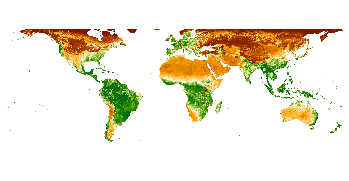

D:\Data\MOD13C1_NDVI//raw_1420070400000.png


In [13]:
# create figure
fig = plt.imshow(array, cmap=phase, vmin=bot, vmax=top, extent=extent2)#vmin=-0.4, vmax=0.4
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

# save to string and compress adaptive
ram = cStringIO.StringIO()    
plt.savefig(ram, bbox_inches='tight', pad_inches=0, dpi=200, transparent=True)
plt.show()
plt.close()    
ram.seek(0)
im = Image.open(ram)
im2 = im.convert('P', palette=Image.ADAPTIVE)    

# save to png
outfolder = r'D:\Data\MOD13C1_NDVI//raw_'
outfile = totimestamp(datetime(2015,1,1))
outpath = outfolder+str(outfile)+'.png'
im2.save(outpath, format='PNG', bits=8)
print outpath

In [8]:
ms = 1418976000000
datetime.datetime.fromtimestamp(ms/1000.0)

datetime.datetime(2014, 12, 19, 16, 0)

In [ ]:
for j in range(0,365,8):#362,8):
    
    ds = gdal.Open(raster[j])
    array = ds.ReadAsArray()
    array = np.flipud(array)
    array = np.ma.masked_array(array, array2.mask)
    array = np.flipud(array)
    #fig = plt.figure(figsize=[16,10])
    fig = plt.imshow(array, cmap=phase, vmin=-0.4, vmax=0.4)
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    outfolder = r'D:\GoogleChromeDownloads\2015-19-01_WebsiteOL3_Rasdaman\sandbox\website_parts\website_image_layer\imgs\ndvi_IM//'
    outpath = outfolder+'ndvi_IM_'+str(j+1).zfill(3)+'.png'
    #print outpath    
    #plt.savefig(outpath, bbox_inches='tight', pad_inches=0, dpi=200, transparent=True)
    
    # This bits is doing all the conversion compression and transparency shizzle    
    ram = cStringIO.StringIO()    
    plt.savefig(ram, bbox_inches='tight', pad_inches=0, dpi=200, transparent=True)
    plt.close()    
    ram.seek(0)
    im = Image.open(ram)
    im2 = im.convert('P', palette=Image.ADAPTIVE)    
    outpath = outfolder+'ndvi_IM_'+str(j+1).zfill(3)+'.png'
    im2.save(outpath, format='PNG', bits=8)    
    print outpath

In [ ]:
im2.info

In [ ]:
img = Image.open(r'D:\GoogleChromeDownloads\2015-19-01_WebsiteOL3_Rasdaman\sandbox\website_parts\website_image_layer\imgs\ndvi_IM//ndvi_IM_001ram.png')
png_info = img.info

In [ ]:
png_info

In [ ]:
for j in range(0,8,8):#362,8):
    
    ds = gdal.Open(raster[j])
    array = ds.ReadAsArray()
    array = np.flipud(array)
    array = np.ma.masked_array(array, array2.mask)

    fig = plt.figure(figsize=[16,10]) 
    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
    ax.set_extent([ex0,ex1,ex2,ex3], ccrs.Geodetic())
    #ax.coastlines(resolution='50m', color='black', linewidth=1)
    #ax_gl = ax.gridlines(draw_labels=True, axes=0)
    #ax_gl.ylabels_right = False
    #ax_gl.xlabels_top = False
    #ax.set_title('standardized anomaly 2009')
    #ax.add_feature(OCEAN, facecolor='aqua', alpha='0.1')
    #ax.add_feature(BORDERS, alpha='0.2')
    #ax.add_feature(LAND, alpha='0.2')
    #ax.coastlines(resolution='10m', color='black', linewidth=1)
    ax.add_feature(BORDERS)
    
    im = ax.imshow(array, origin='upper', extent=img_extent, cmap=phase, vmin=-0.4, vmax=0.4)#, transform=ccrs.Mercator())
    
    #title = 'NDVI Standardized Anomaly 2009 DOY'+raster[j][-7:-4]
    #plt.suptitle(title, y=0.98, fontsize=22)    
    
    #cax = fig.add_axes([0.182, 0.05, 0.661, 0.03]) # location of the legend
    #ticks_ = [-0.4,-0.2,0,0.2,0.4]
    #cb = fig.colorbar(im, cax=cax, ticks=ticks_, norm=norm, orientation='horizontal').set_label('NDVI difference')

#     plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    
#     left  = 0.125  # the left side of the subplots of the figure
#     right = 0.9    # the right side of the subplots of the figure
#     bottom = 0.1   # the bottom of the subplots of the figure
#     top = 0.9      # the top of the subplots of the figure
#     wspace = 0.1   # the amount of width reserved for blank space between subplots
#     hspace = 0.2   # the amount of height reserved for white space between subplots    

    outPath = RasterFolderOut+raster[j][-14:-4]+'.png'

    #plt.savefig(outPath, dpi=90)
    print outPath
    plt.show()
    #plt.close(fig)
    #fig.clf() 

In [ ]:
proj = cartopy.crs.epsg(4326)

In [ ]:
cartopy.crs.Globe

In [ ]:
ccrs.Geodetic

In [ ]:
import cartopy.crs as ccrs
from cartopy.io import srtm
import matplotlib.pyplot as plt


#def main():
ax = plt.axes(projection=ccrs.PlateCarree())

# Get the 1x1 degree SRTM tile for 12E, 47N
elev, crs, extent = srtm.srtm_composite(12, 47, 1, 1)

# Fill the gaps present in the elevation data
#elev_filled = srtm.fill_gaps(elev, 15)

# Add shading simulating the Sun at 10am (South-East)
# and with a low angle (15 degrees above horizon)
#shaded = srtm.add_shading(elev_filled, 135.0, 15.0)

# The plot the result :
plt.imshow(elev, extent=extent, transform=crs,
           cmap='Greys', origin='lower')

plt.title("SRTM Shaded Relief Map")

gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False

plt.show()

In [ ]:
print crs

In [ ]:
ds.GetProjection()

In [ ]:
from pprint import pprint
pprint (vars(crs))

In [ ]:
from pprint import pprint
pprint (vars(crs.globe))

In [ ]:
ds.GetProjectionRef()

# From here its the NDVI 2008/2009 imagery

Sort the raster in the folder based on the doy, necessary for iteration

In [ ]:
raster_sorted = sorted(raster, key=lambda t: int(t[-7:-4]))

For all days in year with 8 step interval select corresponding raster, then select the corresponding raster of each year, create matplotlib using cartopy

In [ ]:
for j in range(1,362,8):
    doy = []
    for i in raster_sorted:
        if int(i[-7:-4]) == j:
            doy.append(i)
    for g in doy:    
#         if int(g[-11:-7]) == 2001:
#             img1 = g
#         if int(g[-11:-7]) == 2002:
#             img2 = g
#         if int(g[-11:-7]) == 2003:
#             img3 = g
#         if int(g[-11:-7]) == 2004:
#             img4 = g
#         if int(g[-11:-7]) == 2005:
#             img5 = g
#         if int(g[-11:-7]) == 2006:
#             img6 = g
#         if int(g[-11:-7]) == 2007:
#             img7 = g
        if int(g[-11:-7]) == 2008:
            img8 = g
        if int(g[-11:-7]) == 2009:
            img9 = g            
#         if int(g[-11:-7]) == 2010:
#             img10 = g
#     ds1 = gdal.Open(img1)
#     array1 = ds1.ReadAsArray()
#     array1 = np.flipud(array1)

#     ds2 = gdal.Open(img2)
#     array2 = ds2.ReadAsArray()
#     array2 = np.flipud(array2)    

#     ds3 = gdal.Open(img3)
#     array3 = ds3.ReadAsArray()
#     array3 = np.flipud(array3)    

#     ds4 = gdal.Open(img4)
#     array4 = ds4.ReadAsArray()
#     array4 = np.flipud(array4)

#     ds5 = gdal.Open(img5)
#     array5 = ds5.ReadAsArray()
#     array5 = np.flipud(array5)

#     ds6 = gdal.Open(img6)
#     array6 = ds6.ReadAsArray()
#     array6 = np.flipud(array6)

#     ds7 = gdal.Open(img7)
#     array7 = ds7.ReadAsArray()
#     array7 = np.flipud(array7)

    ds8 = gdal.Open(img8)
    array8 = ds8.ReadAsArray()
    array8 = np.flipud(array8)

    ds9 = gdal.Open(img9)
    array9 = ds9.ReadAsArray()
    array9 = np.flipud(array9)    

#     ds10 = gdal.Open(img10)
#     array10 = ds10.ReadAsArray()
#     array10 = np.flipud(array10)  
    
    fig = plt.figure(figsize=[16,10])
    
#     ax1 = plt.subplot(3,3,1, projection=ccrs.PlateCarree())
#     ax1.set_extent([72, 136, 52, 17], ccrs.Geodetic())
#     ax1.coastlines(resolution='50m', color='black', linewidth=1)
#     ax1_gl = ax1.gridlines(draw_labels=True, axes=0)
#     ax1_gl.ylabels_right = False
#     ax1_gl.xlabels_top = False
#     ax1_gl.xlabels_bottom = False
#     ax1.set_title('2002')
#     ax1.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
#     ax1.add_feature(cfeature.BORDERS, alpha='0.2')
    
#     ax2 = plt.subplot(3,3,2, projection=ccrs.PlateCarree())
#     ax2.set_extent([72, 136, 52, 17], ccrs.Geodetic())
#     ax2.coastlines(resolution='50m', color='black', linewidth=1)
#     ax2_gl = ax2.gridlines(draw_labels=False, axes=0)
#     ax2.set_title('2003')
#     ax2.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
#     ax2.add_feature(cfeature.BORDERS, alpha='0.2')
    
#     ax3 = plt.subplot(3,3,3, projection=ccrs.PlateCarree())
#     ax3.set_extent([72, 136, 52, 17], ccrs.Geodetic())
#     ax3.coastlines(resolution='50m', color='black', linewidth=1)
#     ax3_gl = ax3.gridlines(draw_labels=False, axes=0)
#     ax3.set_title('2004')
#     ax3.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
#     ax3.add_feature(cfeature.BORDERS, alpha='0.2')
    
#     ax4 = plt.subplot(3,3,4, projection=ccrs.PlateCarree())
#     ax4.set_extent([72, 136, 52, 17], ccrs.Geodetic())
#     ax4.coastlines(resolution='50m', color='black', linewidth=1)
#     ax4_gl = ax4.gridlines(draw_labels=True, axes=0)
#     ax4_gl.ylabels_right = False
#     ax4_gl.xlabels_top = False
#     ax4_gl.xlabels_bottom = False
#     ax4.set_title('2005')
#     ax4.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
#     ax4.add_feature(cfeature.BORDERS, alpha='0.2')
    
#     ax5 = plt.subplot(3,3,5, projection=ccrs.PlateCarree())
#     ax5.set_extent([72, 136, 52, 17], ccrs.Geodetic())
#     ax5.coastlines(resolution='50m', color='black', linewidth=1)
#     ax5_gl = ax5.gridlines(draw_labels=False, axes=0)
#     ax5.set_title('2006')
#     ax5.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
#     ax5.add_feature(cfeature.BORDERS, alpha='0.2')
    
#     ax6 = plt.subplot(3,3,6, projection=ccrs.PlateCarree())
#     ax6.set_extent([72, 136, 52, 17], ccrs.Geodetic())
#     ax6.coastlines(resolution='50m', color='black', linewidth=1)
#     ax6_gl = ax6.gridlines(draw_labels=False, axes=0)
#     ax6.set_title('2007')
#     ax6.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
#     ax6.add_feature(cfeature.BORDERS, alpha='0.2')
    
    ax7 = plt.subplot(1,2,1, projection=ccrs.PlateCarree())
    ax7.set_extent([extent[0], extent[1], extent[2], extent[3]], ccrs.Geodetic())
    ax7.coastlines(resolution='50m', color='black', linewidth=1)
    ax7_gl = ax7.gridlines(draw_labels=True, axes=0)
    ax7_gl.ylabels_right = False
    ax7_gl.xlabels_top = False
    ax7.set_title('2008')
    ax7.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
    ax7.add_feature(cfeature.BORDERS, alpha='0.2')
    
    ax8 = plt.subplot(1,2,2, projection=ccrs.PlateCarree())
    ax8.set_extent([extent[0], extent[1], extent[2], extent[3]], ccrs.Geodetic())
    ax8.coastlines(resolution='50m', color='black', linewidth=1)
    ax8_gl = ax8.gridlines(draw_labels=True, axes=0)
    ax8_gl.ylabels_right = False
    ax8_gl.ylabels_left = False
    ax8_gl.xlabels_top = False
    ax8.set_title('2009')
    ax8.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
    ax8.add_feature(cfeature.BORDERS, alpha='0.2')
    
#     ax9 = plt.subplot(3,3,9, projection=ccrs.PlateCarree())
#     ax9.set_extent([72, 136, 52, 17], ccrs.Geodetic())
#     ax9.coastlines(resolution='50m', color='black', linewidth=1)
#     ax9_gl = ax9.gridlines(draw_labels=True, axes=0)
#     ax9_gl.ylabels_right = False
#     ax9_gl.ylabels_left = False
#     ax9_gl.xlabels_top = False
#     ax9.set_title('2010')
#     ax9.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
#     ax9.add_feature(cfeature.BORDERS, alpha='0.2')
    
#     ax1.imshow(array2, origin='upper', extent=img_extent, cmap=cmap, norm=norm)#, transform=ccrs.Mercator())
#     ax2.imshow(array3, origin='upper', extent=img_extent, cmap=cmap, norm=norm)#, transform=ccrs.Mercator())
#     ax3.imshow(array4, origin='upper', extent=img_extent, cmap=cmap, norm=norm)#, transform=ccrs.Mercator())
#     ax4.imshow(array5, origin='upper', extent=img_extent, cmap=cmap, norm=norm)#, transform=ccrs.Mercator())
#     ax5.imshow(array6, origin='upper', extent=img_extent, cmap=cmap, norm=norm)#, transform=ccrs.Mercator())
#     ax6.imshow(array7, origin='upper', extent=img_extent, cmap=cmap, norm=norm)#, transform=ccrs.Mercator())
    ax7.imshow(array8, origin='upper', extent=img_extent, cmap=cmap, norm=norm)#, transform=ccrs.Mercator())
    im = ax8.imshow(array9, origin='upper', extent=img_extent, cmap=cmap, norm=norm)#, transform=ccrs.Mercator())
#     im = ax9.imshow(array10, origin='upper', extent=img_extent, cmap=cmap, norm=norm), transform=ccrs.Mercator())
    
    title = 'NVAI DOY'+g[-7:-4]
    plt.suptitle(title, y=0.98, fontsize=22)    
    
    cax = fig.add_axes([0.15, 0.05, 0.7, 0.03]) # location of the legend
    cb = fig.colorbar(im, cax=cax, ticks=[-1]+bounds+[1], norm=norm, extend='both', extendfrac='auto', orientation='horizontal').set_label('NDVI Difference')

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    
    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.1   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots


    #plt.tight_layout()
    outPath = r'D:\Data\NVAI_PNG//NVAI'+g[-7:-4]+'.png' # [-15:-4] original
    print outPath
    #fig.savefig(outPath, dpi=200)
    #plt.savefig(outPath, dpi=200)
    plt.show()
    #plt.close(fig)
    fig.clf() 
    #ax.cla()
    doy = None

In [ ]:



fig = plt.figure(figsize=[16,10])


ax1 = plt.subplot(3,3,1, projection=ccrs.PlateCarree())
ax1.set_extent([72, 136, 52, 17], ccrs.Geodetic())
ax1.coastlines(resolution='50m', color='black', linewidth=1)
ax1_gl = ax1.gridlines(draw_labels=True, axes=0)
ax1_gl.ylabels_right = False
ax1_gl.xlabels_top = False
ax1_gl.xlabels_bottom = False
ax1.set_title('2001')
ax1.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
ax1.add_feature(cfeature.BORDERS, alpha='0.2')

ax2 = plt.subplot(3,3,2, projection=ccrs.PlateCarree())
ax2.set_extent([72, 136, 52, 17], ccrs.Geodetic())
ax2.coastlines(resolution='50m', color='black', linewidth=1)
ax2_gl = ax2.gridlines(draw_labels=False, axes=0)
ax2.set_title('2002')
ax2.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
ax2.add_feature(cfeature.BORDERS, alpha='0.2')

ax3 = plt.subplot(3,3,3, projection=ccrs.PlateCarree())
ax3.set_extent([72, 136, 52, 17], ccrs.Geodetic())
ax3.coastlines(resolution='50m', color='black', linewidth=1)
ax3_gl = ax3.gridlines(draw_labels=False, axes=0)
ax3.set_title('2003')
ax3.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
ax3.add_feature(cfeature.BORDERS, alpha='0.2')

ax4 = plt.subplot(3,3,4, projection=ccrs.PlateCarree())
ax4.set_extent([72, 136, 52, 17], ccrs.Geodetic())
ax4.coastlines(resolution='50m', color='black', linewidth=1)
ax4_gl = ax4.gridlines(draw_labels=True, axes=0)
ax4_gl.ylabels_right = False
ax4_gl.xlabels_top = False
ax4_gl.xlabels_bottom = False
ax4.set_title('2004')
ax4.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
ax4.add_feature(cfeature.BORDERS, alpha='0.2')

ax5 = plt.subplot(3,3,5, projection=ccrs.PlateCarree())
ax5.set_extent([72, 136, 52, 17], ccrs.Geodetic())
ax5.coastlines(resolution='50m', color='black', linewidth=1)
ax5_gl = ax5.gridlines(draw_labels=False, axes=0)
ax5.set_title('2005')
ax5.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
ax5.add_feature(cfeature.BORDERS, alpha='0.2')

ax6 = plt.subplot(3,3,6, projection=ccrs.PlateCarree())
ax6.set_extent([72, 136, 52, 17], ccrs.Geodetic())
ax6.coastlines(resolution='50m', color='black', linewidth=1)
ax6_gl = ax6.gridlines(draw_labels=False, axes=0)
ax6.set_title('2006')
ax6.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
ax6.add_feature(cfeature.BORDERS, alpha='0.2')

ax7 = plt.subplot(3,3,7, projection=ccrs.PlateCarree())
ax7.set_extent([72, 136, 52, 17], ccrs.Geodetic())
ax7.coastlines(resolution='50m', color='black', linewidth=1)
ax7_gl = ax7.gridlines(draw_labels=True, axes=0)
ax7_gl.ylabels_right = False
ax7_gl.xlabels_top = False
ax7.set_title('2007')
ax7.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
ax7.add_feature(cfeature.BORDERS, alpha='0.2')

ax8 = plt.subplot(3,3,8, projection=ccrs.PlateCarree())
ax8.set_extent([72, 136, 52, 17], ccrs.Geodetic())
ax8.coastlines(resolution='50m', color='black', linewidth=1)
ax8_gl = ax8.gridlines(draw_labels=True, axes=0)
ax8_gl.ylabels_right = False
ax8_gl.ylabels_left = False
ax8_gl.xlabels_top = False
ax8.set_title('2008')
ax8.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
ax8.add_feature(cfeature.BORDERS, alpha='0.2')

ax9 = plt.subplot(3,3,9, projection=ccrs.PlateCarree())
ax9.set_extent([72, 136, 52, 17], ccrs.Geodetic())
ax9.coastlines(resolution='50m', color='black', linewidth=1)
ax9_gl = ax9.gridlines(draw_labels=True, axes=0)
ax9_gl.ylabels_right = False
ax9_gl.ylabels_left = False
ax9_gl.xlabels_top = False
ax9.set_title('2009')
ax9.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
ax9.add_feature(cfeature.BORDERS, alpha='0.2')

#ax9.text(0.5, 0.5, 'Text centered at (0.5, 0.5)\nin data coordinates.', fontsize=14)



#ax1.imshow(img, origin='upper', extent=img_extent, cmap=cmap, norm=norm)#, transform=ccrs.Mercator())
#ax2.imshow(img, origin='upper', extent=img_extent, cmap=cmap, norm=norm)#, transform=ccrs.Mercator())
#ax3.imshow(img, origin='upper', extent=img_extent, cmap=cmap, norm=norm)#, transform=ccrs.Mercator())
#ax4.imshow(img, origin='upper', extent=img_extent, cmap=cmap, norm=norm)#, transform=ccrs.Mercator())
#ax5.imshow(img, origin='upper', extent=img_extent, cmap=cmap, norm=norm)#, transform=ccrs.Mercator())
#ax6.imshow(img, origin='upper', extent=img_extent, cmap=cmap, norm=norm)#, transform=ccrs.Mercator())
#ax7.imshow(img, origin='upper', extent=img_extent, cmap=cmap, norm=norm)#, transform=ccrs.Mercator())
#ax8.imshow(img, origin='upper', extent=img_extent, cmap=cmap, norm=norm)#, transform=ccrs.Mercator())
im = ax9.imshow(img, origin='upper', extent=img_extent, cmap=cmap, norm=norm)#, transform=ccrs.Mercator())
title = 'NDVI Anomaly DOY'+rasterBase[-7:-4]
plt.suptitle(title, y=0.98, fontsize=22)






cax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
cb = fig.colorbar(im, cax=cax, ticks=[-1]+bounds+[1], norm=norm, extend='both', extendfrac='auto', orientation='horizontal').set_label('NDVI Difference')


outPath = r'D:\Data\NDVIanomalytimeseriesPNG//__TEST.png' # [-15:-4] original
print outPath
fig.savefig(outPath, dpi=200)


In [ ]:
import cartopy 
# Set up a standard map for latlon data.
#geo_axes = pyplot.axes(projection=cartopy.crs.PlateCarree())

# Set up an OSGB map.
geo_axes = pyplot.subplot(2, 2, 1, projection=cartopy.crs.OSGB())

In [ ]:
fig = plt.figure()
# plot 1

ax1
ax1 = plt.axes(projection=ccrs.PlateCarree())

ax1.set_extent([72, 136, 52, 17], ccrs.Geodetic())
ax1.coastlines(resolution='50m', color='black', linewidth=1)

ax1.gridlines(draw_labels=True, axes=0)
ax1.add_feature(cfeature.OCEAN, facecolor='aqua', alpha='0.1')
ax1.add_feature(cfeature.BORDERS, alpha='0.2')


#ax1 = fig.add_subplot(3, 3, 1)
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)
ax4 = fig.add_subplot(3, 3, 4)
ax5 = fig.add_subplot(3, 3, 5)
ax6 = fig.add_subplot(3, 3, 6)
ax7 = fig.add_subplot(3, 3, 7)
ax8 = fig.add_subplot(3, 3, 8)
ax9 = fig.add_subplot(3, 3, 9)
plt.tight_layout()